In [4]:
using OrdinaryDiffEq, ParameterizedFunctions
using DiffEqSensitivity
using Plots, LaTeXStrings

In [8]:
figdir = "figures/";

## Standard virus load function

The standard virus load function with three main phases given by

$$V(t)=v_1(t)v_2(t)v_3(t),$$

where $v _1$ describes the initial growth phase between $a _1$ and $a _2$ , $v _2$ the intermediate slow decay
phase between $a _2$ and $b _1$, and $v _3$ the final decay phase between $b _1$ and $b _2$. These functions are given as sigmoid and exponential functions, respectively

$$
\begin{aligned}
v_1(t) & = 1 + \frac{V_{\max} - 1}{2} \left[ \tanh \left( \frac{6}{a_2 - a_1} \left( t - \frac{a_1 + a_2}{2} \right) \right) - \tanh  \left( -3\frac{a_2 + a_1}{a_2 - a_1} \right) \right] \\
v_2(t) & = (1 - H(t - a_2)) + H(t - a_2)e^{-\alpha(t - a_2)} \\
v_3(t) & = 1 - \frac{1 - V_{\min}}{2} \left[ \tanh \left( \frac{6}{b_2 - b_1} \left( t - \frac{b_1 + b_2}{2} \right) \right) - \tanh  \left( -3\frac{b_2 + b_1}{b_2 - b_1} \right) \right],
\end{aligned}
$$

where $H(t)$ denotes the Heaviside function.

In [9]:
heaviside(x::AbstractFloat) = ifelse(x < 0, zero(x), ifelse(x > 0, one(x), oftype(x,0.5)))
v₁(t, a₁, a₂, Vmax) = 1. + (Vmax - 1.0)*(tanh(6.0*(t - (a₁ + a₂)/2)/(a₂ - a₁)) - tanh(-3.0*(a₂ + a₁)/(a₂ - a₁)))/2
v₂(t, a₂, α) = 1. - heaviside(t - a₂) + heaviside(t - a₂)*exp(-α*(t - a₂))
v₃(t, b₁, b₂, Vmin) = 1. - (1.0 - Vmin)*(tanh(6.0*(t - (b₁ + b₂)/2)/(b₂ - b₁)) - tanh(-3.0*(b₂ + b₁)/(b₂ - b₁)))/2
function VLF(t, a₁, a₂, b₁, b₂, α, Vmax, Vmin)
    v₁(t, a₁, a₂, Vmax)*v₂(t, a₂, α)*v₃(t, b₁, b₂, Vmin)
end

VLF (generic function with 1 method)

## Model


In [53]:
function model(du, u, p, t)
    AngI, AngII, AT1RAngII, AT2RAngII, Ang17, ACE2m, ACE2p, ACE2i, P_plasma, P, N, D, C_A = u
    PRA, c_ACE, c_NEP, h_AngI, k_ACE2, c_AT1R, c_AT2R, h_AngII, h_AT1R, h_AT2R, h_Ang17, S_ACE2m, c_ADAM17,
        c_Cov19, K_mACE2i, c_ACE2i, h_ACE2, k_burst, k_ACE2P, k_Cov19, k_pg, P_∞, k_pm, s_m, μ_m, k_mp,
        k_pn, c_∞, s_nr, μ_nr, k_AT1R, μ_n, k_nn, k_np, k_nd, k_dn, μ_d, x_dn, s_c, k_cn, k_ACE2p,
        k_Ang17, k_AT2R, μ_c, k_cnd = p
    f(V) = V/(1 + (C_A/c_∞)^2)
    f_s(V) = V^6/(x_dn^6 + V^6)
    R = f(k_nn*N + k_np*P + k_nd*D)
    Q = f(N + k_cnd*D)
    # RAS
    du[1] = dAngI = PRA - (c_ACE + c_NEP)*AngI - log(2.)/h_AngI*AngI
    du[2] = dAngII = c_ACE*AngI - k_ACE2*ACE2m*AngII - (c_AT1R + c_AT2R)*AngII - log(2.)*AngII/h_AngII
    du[3] = dAT1AngII = c_AT1R*AngII - log(2.)*AT1RAngII/h_AT1R
    du[4] = dAT2AngII = c_AT2R*AngII - log(2.)*AT2RAngII/h_AT2R
    du[5] = dAng17 = c_NEP*AngI + k_ACE2*ACE2m*AngII - log(2.)*Ang17/h_Ang17
    du[6] = dACE2m = S_ACE2m - (c_ADAM17 + c_AT1R*AT1RAngII +
        c_Cov19*P_plasma/(K_mACE2i + P_plasma + c_ACE2i*ACE2p))*ACE2m - log(2.)*ACE2m/h_ACE2
    du[7] = dACE2p = c_ADAM17*ACE2m - log(2.)*ACE2p/h_ACE2
    du[8] = dACE2i = (c_AT1R*AT1RAngII + c_Cov19*P_plasma/(K_mACE2i + P_plasma + c_ACE2i*ACE2p))*ACE2m -
        log(2.)*ACE2i/h_ACE2
    du[9] = dP_plasma = k_burst*P - k_ACE2P*ACE2p*P_plasma -
        c_Cov19*P_plasma*ACE2m/(K_mACE2i + P_plasma + c_ACE2i*ACE2p)
    # Inflamatory response
    du[10] = dP = k_Cov19*c_Cov19*P_plasma*ACE2m/(K_mACE2i + P_plasma + c_ACE2i*ACE2p) +
        k_pg*P*(1 - P/P_∞) - k_pm*s_m*P/(μ_m + k_mp*P) - k_pn*f(N) - k_burst*P
    du[11] = dN = s_nr*R/(μ_nr + R) + k_AT1R*AT1RAngII - μ_n*N
    du[12] = dD = k_dn*f_s(f(N)) - μ_d*D
    du[13] = dC_A = s_c + k_cn*Q/(1 + Q) + k_ACE2p*ACE2p + k_Ang17*Ang17 + k_AT2R*AT2RAngII - μ_c*C_A
end

model (generic function with 1 method)

In [76]:
u0 = [
    0.0 # AngI: Angiotensin I
    0.0 # AngII: Angiotensin II
    0.0 # AT1AngII: Ang II bound to Ang II type 1 receptor (AT1R)
    0.0 # AT2AngII: Ang II bound to Ang II type 2 receptor (AT2R)
    0.0 # Ang17: Angiotensis (1-7)
    0.940 # ACE2m: Membrane bound ACE2
    0.045 # ACE2p: Plasma ACE2
    0.015 # ACE2i: Internalized ACE2
    0.0 # P_plasma: Plasma SARS-CoV-2
    0.0 # P: Internilized SARS-CoV-2
    0.0 # N: Inflamatory agents
    0.0 # D: tissue damage
    0.0 # C_A: anti-inflamatory mediators
]
varnames = [:AngI, :AngII, :AT1RAngII, :AT2RAngII, :Ang17, :ACE2m, :ACE2p, :ACE2i, :P_plasma, :P, :N, :D, :C_A]
tspan = (0.0, 100.0)
pars = [   
    8135.2 # PRA
    5.81 # c_ACE
    0.76 # c_NEP
    8.5 #? h_AngI
    1.0 #? k_ACE2
    1.48e-6 # c_AT1R
    3.9 # c_AT2R
    8.5 #? h_AngII
    8.5 #? h_AT1R
    8.5 #? h_AT2R
    8.5 #? h_Ang17
    1.36e-2 # S_ACE2m
    6.51e-5 # c_ADAM17
    3e-6 # c_Cov19
    1.0 #? K_mACE2i
    1.0 #? c_ACE2i
    8.5 # h_ACE2
    1e-3 # k_burst
    2.1e-2 #? k_ACE2P
    1e3 # k_Cov19
    0.021 # k_pg
    2.01e6 # P_∞
    0.6 # k_pm
    0.005 # s_m
    0.002 # μ_m
    0.01 # k_mp
    1.8 # k_pn
    0.28 # c_∞
    0.08 # s_nr
    0.12 # μ_nr
    3.5e-3 # k_AT1R
    0.05 # μ_n
    0.01 # k_nn
    0.1 # k_np
    0.02 # k_nd
    0.35 # k_dn
    0.02 # μ_d
    0.06 # x_dn
    0.0125 # s_c
    0.04 # k_cn
    2.1e-2 # k_ACE2p
    1e-2 # k_Ang17
    5.1e-3 # k_AT2R
    5.1e-3 # μ_c
    48 # k_cnd
]

45-element Array{Float64,1}:
 8135.2
    5.81
    0.76
    8.5
    1.0
    1.48e-6
    3.9
    8.5
    8.5
    8.5
    8.5
    0.0136
    6.51e-5
    ⋮
    0.1
    0.02
    0.35
    0.02
    0.06
    0.0125
    0.04
    0.021
    0.01
    0.0051
    0.0051
   48.0

In [77]:
prob = ODEProblem(model, u0, tspan, pars)

ODEProblem with uType Array{Float64,1} and tType Float64. In-place: true
timespan: (0.0, 100.0)
u0: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

In [78]:
sol = solve(prob, Tsit5());

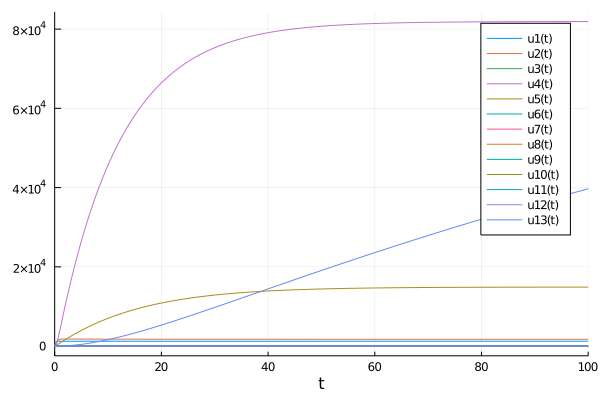

In [79]:
plot(sol)

In [80]:
sol.u[end]

13-element Array{Float64,1}:
  1222.9365342370133
  1713.3146641875578
     0.031083502050868943
 81909.22837728981
 14887.026955559275
     0.16659483939393804
     0.00013268420272737226
     9.36175333334846e-8
    -8.368737781021642e-12
    -1.3397406050404848e-13
     0.0021406538292334876
     2.9034643630698584e-42
 39688.55493653423